# Building your own Object Detector from scratch

This notebook has educational purposes only.

It shows how to build a simple Object Detector from scratch using Tensorflow & Keras.

The model is trained over the Labeled Mask database.

Check this story on medium for more details: https://medium.com/@doleron/building-your-own-object-detector-from-scratch-bfeadfaddad8

## Getting the data

Before run this notebook, it is necessary to download the archive file with the training images and respective annotation files.

The file is available on Kaggle: https://www.kaggle.com/datasets/techzizou/labeled-mask-dataset-yolo-darknet

Hit the download button and copy the `archive.zip` to the `data` folder. After that, run the next cell.

In [1]:
import glob
import os, random
import tensorflow as tf
from tensorflow import keras

In [2]:
import tensorflow as tf


def tpu_start(device_name):
    device = device_name
    # TPU and GPU mechanism
    if device == "TPU":
        print("Connecting to TPU")
        try:
            # Detects weather system has TPU.
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            print("Running on TPU!", tpu.master())
        except ValueError:
            print("Could not connect to TPU.")
            tpu = None
        if tpu:
            try:
                print("Starting TPU")
                # Connects to the TPU cluster
                tf.config.experimental_connect_to_cluster(tpu)
                # Starts TPU cluster
                tf.tpu.experimental.initialize_tpu_system(tpu)
                # Object gives TPU cluster with 7 replicas
                strategy = tf.distribute.experimental.TPUStrategy(tpu)
                print("TPU started.")
            except:
                print("Failed to start TPU.")
        else:
            device = "GPU"
    # If no TPU then...
    if device != "TPU":
        print("Using single GPU and CPU.")
        strategy = tf.distribute.get_strategy()

    if device == "GPU":
        print(
            f'Number of GPU available: {len(tf.config.experimental.list_physical_devices("GPU"))}'
        )

    AUTO = tf.data.experimental.AUTOTUNE
    REPLICAS = strategy.num_replicas_in_sync
    print(f"Replicas: {REPLICAS}")
    print("Return auto, replica and strategy object in the same order.")
    return AUTO, REPLICAS, strategy


In [3]:
AUTO, REPLICAS, strategy = tpu_start('GPU')

Using single GPU and CPU.
Number of GPU available: 1
Replicas: 1
Return auto, replica and strategy object in the same order.


In [4]:
# import pathlib
# import shutil

# data_dir_path = "data/"
# shutil.unpack_archive(data_dir_path + "/archive.zip", data_dir_path)

# data_dir = pathlib.Path(data_dir_path + "/obj/").with_suffix('')

# image_files = list(data_dir.glob('*.jpg'))
# print(len(image_files))

image_files = glob.glob('../../mask_dataset/obj/*.jpg')

The previous cell uncompress the `archive.zip` file and store the images & text files in the `data/obj` folder. We can inspect the contents of those files as shown below:  

In [39]:
import PIL

In [42]:
# np.array(PIL.Image.open(image_files[0])).shape

In [ ]:
input_size = 244

def format_image(img, box):
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

In [44]:
import scipy.io
mat = scipy.io.loadmat('../../IMDB_WIKI/imdb/imdb.mat')

In [5]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

../../mask_dataset/obj/462-with-mask.jpg


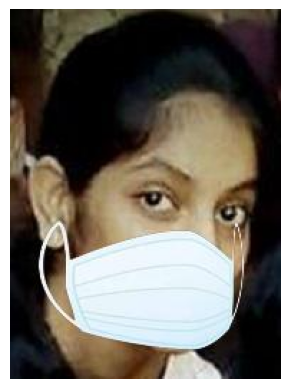

In [6]:
sample_img_path = str(image_files[103])
print(sample_img_path)
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Basically, the data consist of images files and respective annotation files. Each annotation file has one or more lines in which we can find the class and bounding box coordinates:

In [7]:
sample_annotation_path = sample_img_path[0:-4] + '.txt'
with open(sample_annotation_path) as f:
    print(f.readlines())

['0 0.5873015873015873 0.6143410852713178 0.6772486772486772 0.7093023255813954\n']


The following function filter the files, generating 3 lists:

- training files (70% of images)
- validation files (20% of images)
- test files (last 10%)

In [8]:
files = []
discarded, masked_instance = 0, 0

In [9]:
def list_files(full_data_path = "data/obj/", image_ext = '.jpg', split_percentage = [70, 20]):


    files = []

    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp:
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue


                strip = file[0:len(file) - len(".txt")]
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")

    random.shuffle(files)

    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)

    return files[0:split_training], files[split_training:split_validation], files[split_validation:]


In [10]:
training_files, validation_files, test_files = list_files(full_data_path='../../mask_dataset/obj/')

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

218 file(s) discarded
1292 valid case(s)
832 are masked cases
904 training files
258 validation files
130 test files


This is actually a small dataset. We have only 904 images to train our model!

Let's combine image and annotations in order to check if we actually understand how to deal with the data.

In addition, let's format the images for the input size of our model (244 x 244)

In [11]:
input_size = 244

def format_image(img, box):
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

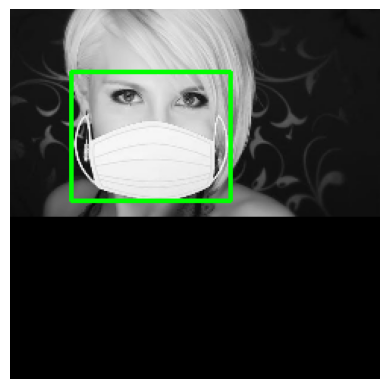

In [12]:
temp_img = cv.imread("../../mask_dataset/obj/5-with-mask.jpg", cv.IMREAD_GRAYSCALE)

temp_box = [0.38183279742765275, 0.6171428571428571, 0.43569131832797425, 0.6285714285714286]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 255, 0), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

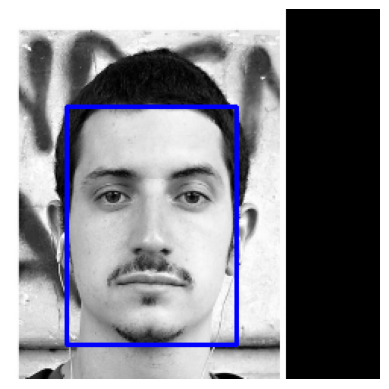

In [13]:
temp_img = cv.imread("../../mask_dataset/obj/149.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.5171875, 0.5911214953271028, 0.621875, 0.6495327102803738]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 0, 255), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

The dataset is composed by different images of peoplse using or not masks. Let's create a tensorflow dataset with the images:

In [14]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

# uncomment the following line if you want to force CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print(tf.__version__)

2.9.2


In [15]:
def data_load(files, full_data_path = "data/obj/", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp:
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)

    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [16]:
raw_train_ds = data_load(training_files, full_data_path='../../mask_dataset/obj/')

In [17]:
raw_validation_ds = data_load(validation_files, full_data_path='../../mask_dataset/obj/')

In [18]:
raw_test_ds = data_load(test_files, full_data_path='../../mask_dataset/obj/')

The training, validation & test datasets must be set up in order to follow the tensorflow guideline (https://www.tensorflow.org/datasets/performances):

In [19]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [20]:
BATCH_SIZE = 32

# see https://www.tensorflow.org/guide/data_performance

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [21]:
train_ds = tune_training_ds(raw_train_ds)

In [33]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    # dataset = dataset.repeat()
    return dataset

In [34]:
validation_ds = tune_validation_ds(raw_validation_ds)

Let's inspect our training dataset:

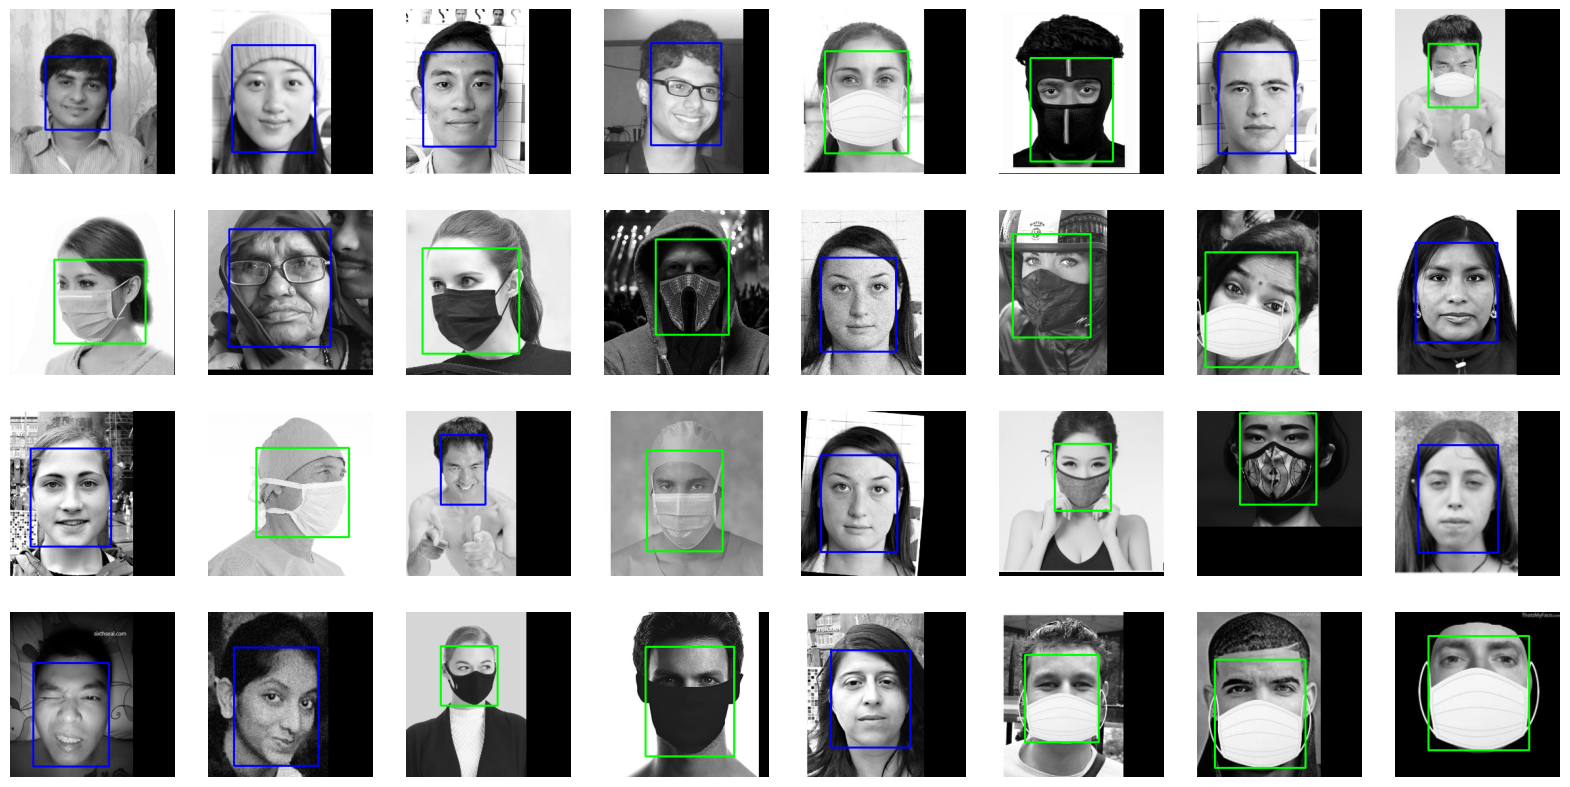

In [24]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

Based on the image above, we can realize that the training dataset is correctly set. Blue rectangles represent bounding box of **unmask people**. A green rectangle represent a masked person.

Once the data is ready, we can start our modelling and training.

## The model

Since we are building a object detector, our model have two heads: one to classify the object type (or label or class) and other head to output the object bounding box. In order to achieve that, we use Tensorflow Funcional API, as follows:

In [25]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  return x

def build_classifier_head(inputs):
  return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_model(inputs):

    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' },
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

It is notewhortly that each network head has a specific set of loss function and metrics:

In [26]:
with strategy.scope():
    model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 242, 242, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 121, 121, 16  0          ['conv2d[0][0]']                 
 ing2D)                         )                                                             

Since we have few data, we must keep the model small. The model can be vizualized below:

In [27]:
# plot_model requires graphviz & pydot
# see https://github.com/XifengGuo/CapsNet-Keras/issues/7#issuecomment-370745440
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Model training

Our model is all set and we can start the training, as shown in the next cell:

In [29]:
with strategy.scope():
    EPOCHS = 100

    history = model.fit(train_ds,
                        steps_per_epoch=(len(training_files) // BATCH_SIZE),
                        validation_data=validation_ds, validation_steps=1,
                        epochs=EPOCHS,
                        verbose=1)


Epoch 1/100
28/28 [==============================] - 1s 39ms/step - loss: 0.0424 - classifier_head_loss: 0.0315 - regressor_head_loss: 0.0109 - classifier_head_accuracy: 0.9900 - regressor_head_mse: 0.0109 - val_loss: 0.4611 - val_classifier_head_loss: 0.4351 - val_regressor_head_loss: 0.0260 - val_classifier_head_accuracy: 0.9219 - val_regressor_head_mse: 0.0260
Epoch 2/100
28/28 [==============================] - 1s 40ms/step - loss: 0.0524 - classifier_head_loss: 0.0415 - regressor_head_loss: 0.0110 - classifier_head_accuracy: 0.9888 - regressor_head_mse: 0.0110 - val_loss: 0.6691 - val_classifier_head_loss: 0.6437 - val_regressor_head_loss: 0.0254 - val_classifier_head_accuracy: 0.8594 - val_regressor_head_mse: 0.0254
Epoch 3/100
28/28 [==============================] - 1s 37ms/step - loss: 0.0380 - classifier_head_loss: 0.0282 - regressor_head_loss: 0.0098 - classifier_head_accuracy: 0.9922 - regressor_head_mse: 0.0098 - val_loss: 0.4337 - val_classifier_head_loss: 0.4113 - val_re

In [35]:
preds = model.predict(validation_ds, verbose=1)

5/5 [==============================] - 0s 37ms/step


In [36]:
preds

[array([[6.82348173e-06, 9.99993205e-01],
        [9.99412179e-01, 5.87860064e-04],
        [8.52007531e-08, 9.99999881e-01],
        [1.00000000e+00, 8.07603984e-11],
        [3.32858950e-01, 6.67141080e-01],
        [1.00000000e+00, 8.75752193e-10],
        [1.00000000e+00, 1.32673144e-08],
        [1.00000000e+00, 2.94538338e-10],
        [6.23670621e-06, 9.99993801e-01],
        [2.89006182e-03, 9.97109950e-01],
        [1.06412843e-01, 8.93587112e-01],
        [1.00000000e+00, 2.45343901e-09],
        [1.00000000e+00, 1.81829031e-11],
        [9.99999881e-01, 1.56254501e-07],
        [1.00000000e+00, 3.61897198e-15],
        [4.79903072e-02, 9.52009737e-01],
        [1.00000000e+00, 1.76971700e-08],
        [9.99602854e-01, 3.97111813e-04],
        [1.00000000e+00, 1.77673054e-09],
        [5.20065606e-01, 4.79934424e-01],
        [1.63442266e-04, 9.99836564e-01],
        [9.90421414e-01, 9.57860146e-03],
        [9.99961138e-01, 3.88265180e-05],
        [9.99466836e-01, 5.3316861

The training performance can be checked in the charts below.

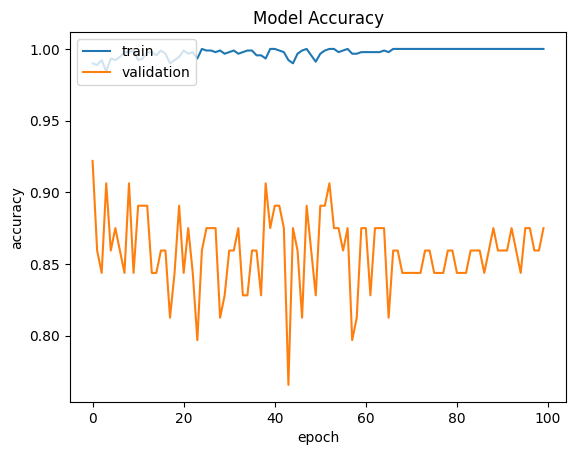

In [30]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

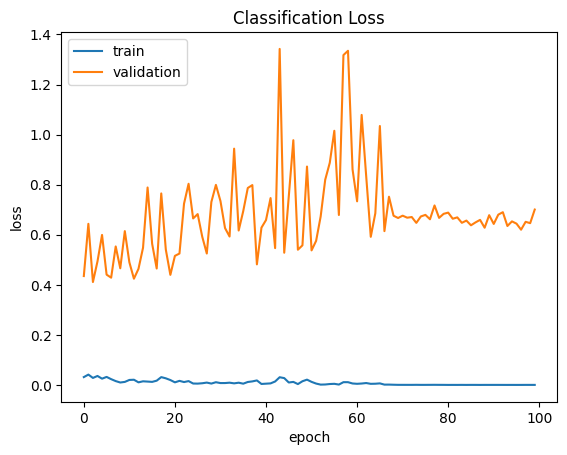

In [31]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

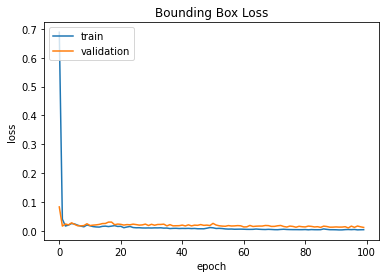

In [ ]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluation

The best way to evaluate the end model performance is by using IoU - intersection over Union - metrics. The following implementation of IoU was adapted from PyImage Search website:

In [ ]:
# adapted from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [ ]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

The model performance is finally evaluated on the test dataset. Green boxes indicaates correct classification in which the predicted label (masked-unmasked) matches with the actual label.
A red box indicate a wrong classification.

20


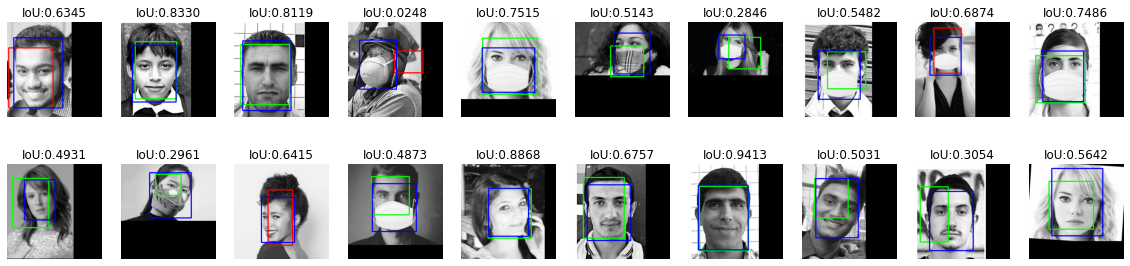

In [ ]:
plt.figure(figsize=(20, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

## Conclusion

Taking in consideration the small size of the data used for training and the fact of training the model from scratch without transfer learning, the results above are surprisingly good. We can think in ways to improve it even more:

- The first option to improve the bound box and classificataion performance is increase the training data size which can be easily achieved by data augmentation.

- Tweaking the hyperparameters and finding on way to improve the regularization can either improve the results, reducing the classification and regression errors.

A good enhacement here would be calculating mAP comparing the results to one or more object detectors. Implementing other features like multiscale and multiple detections can also provide a solid understand of real challengings in developing an battle-tested object detector.